# Investigating the differences between men and women's emails and how often they apologize, put themselves down, and more

In [10]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import matplotlib.pyplot as plt
from scipy import stats
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools
from scipy import stats

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\baile\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\baile\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Clean the data

In [5]:
enron_emails = pd.read_csv('clean_enron_emails.csv')
enron_emails = enron_emails.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'text_tokens', 'text'])

In [6]:
enron_emails['clean_text'] = [row.lower() for row in enron_emails['clean_text']]

In [7]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'how', "wouldn't", 'now', 'on', 'we', 'they', 'off', 'there', 'not', 'just', 'its', "hadn't", 'don', "she's", 'this', "you're", 'him', 'she', 'her', 'below', 'shouldn', 'shan', 'why', "haven't", 'very', 'your', 'have', 'didn', "aren't", 'both', "you'd", 'few', 'doesn', "isn't", 'had', 'needn', 'over', 'his', 'wouldn', 'can', 'their', 'up', 'all', 'only', "didn't", 'to', 'ours', 'do', 'it', 'm', 'no', 'mightn', 'once', 'should', 'me', 'out', 'again', 'further', 'he', 'y', 'at', 'through', 'above', 'any', 'are', 'these', 'o', 're', "mustn't", 'each', "shan't", 'them', 'hers', 'those', 'down', 'yourselves', 'hasn', 'during', 'because', 'by', 'than', 'theirs', 'has', "shouldn't", 'is', 'my', 'our', 'were', 'of', "weren't", 'you', 'did', 've', 'themselves', "hasn't", 'haven', "you've", 'so', 'where', 'as', 'same', 'i', 'doing', "doesn't", 'will', 'be', "needn't", 'such', 'other', 'ain', 'was', "you'll", 't', "that'll", 'the', 'into', 'some', "don't", 'ma', 'in', 'who', 'being', 'nor', 'wer

In [8]:
enron_emails['text_tokens'] = [nltk.word_tokenize(text) for text in enron_emails['clean_text']]
enron_emails['text_no_stop'] = [[w for w in word_tokens if not w in stop_words] for word_tokens in enron_emails['text_tokens']]

In [9]:
nltk.download('averaged_perceptron_tagger')
enron_emails['text_ns_pos'] = [nltk.pos_tag(text) for text in enron_emails['text_no_stop']]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\baile\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
enron_emails.head()

,date,sender,recipient1,subject,sender_name,recipient_name,sender_gender,recipient_gender,clean_text,text_tokens,text_no_stop,text_ns_pos
0,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,NaN,Phillip,Tim,male,male,here is our forecast,"[here, is, our, forecast]",[forecast],"[(forecast, NN)]"
1,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,Phillip,John,male,male,traveling to have a business meeting takes the...,"[traveling, to, have, a, business, meeting, ta...","[traveling, business, meeting, takes, fun, tri...","[(traveling, VBG), (business, NN), (meeting, N..."
2,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,Phillip,Leah,male,female,test successful. way to go!!!,"[test, successful, ., way, to, go, !, !, !]","[test, successful, ., way, go, !, !, !]","[(test, NN), (successful, JJ), (., .), (way, N..."
3,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,NaN,Phillip,Randall,male,male,randy can you send me a schedule of the sala...,"[randy, can, you, send, me, a, schedule, of, t...","[randy, send, schedule, salary, level, everyon...","[(randy, JJ), (send, NN), (schedule, NN), (sal..."
4,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Phillip,Greg,male,male,lets shoot for tuesday at 1145.,"[lets, shoot, for, tuesday, at, 1145, .]","[lets, shoot, tuesday, 1145, .]","[(lets, NNS), (shoot, VBP), (tuesday, JJ), (11..."


In [12]:
enron_female_sender = enron_emails[enron_emails['sender_gender'] =='female'].reset_index()
enron_male_sender = enron_emails[enron_emails['sender_gender'] =='male'].reset_index()
enron_andy_sender = enron_emails[enron_emails['sender_gender'] =='andy'].reset_index()

In [13]:
#function to count the number of times any related words (given by list_of_words) are included in an email 
def count_these_words(text, list_of_words):
    total = 0
    for word in list_of_words:
        total += text.count(word)
        
    return total

## Let's look into how often women and men say apologetic words in their emails

In [14]:
apologetic_words =  ['apologize', 'apology', 'sorry', 'forgive', 'regret']

enron_female_sender['num_apologetic'] = [count_these_words(tokens, apologetic_words) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['percent_apologetic'] = [(enron_female_sender.loc[row, 'num_apologetic'] / len(enron_female_sender.loc[row, 'text_tokens']))  for row in range(len(enron_female_sender))]
enron_male_sender['num_apologetic'] =  [count_these_words(tokens, apologetic_words) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['percent_apologetic'] = [(enron_male_sender.loc[row, 'num_apologetic'] / len(enron_male_sender.loc[row, 'text_tokens']))  for row in range(len(enron_male_sender))]


In [15]:
print((len(enron_female_sender[enron_female_sender['num_apologetic'] > 0]) / len(enron_female_sender)) * 100, '% of women said at least one apology word in their email')
print((len(enron_male_sender[enron_male_sender['num_apologetic'] > 0]) / len(enron_male_sender)) * 100, '% of men said at least one apology word in their email')

5.696526508226691 % of women said at least one apology word in their email
3.598563696919234 % of men said at least one apology word in their email


That told us how many of the emails had at least one apology word... let's see the average amount of apology words per email now

In [16]:
print('The female average number of apologetic words is', enron_female_sender['num_apologetic'].mean(), 'and the male average is', enron_male_sender['num_apologetic'].mean())

The female average number of apologetic words is 0.06318098720292505 and the male average is 0.038639675270607826


In [17]:
#ratio = 1.6355

because our p value is so small, we reject the null hypothesis and know that the data is not normal


## Next, let's look at how often women and men say words that indicate they don't know what they are talking about

In [18]:
unsure_words = ['unsure', 'hesitant', 'wonder', 'believe', 'think', 'guess', 'uncertain', 'suppose', 'maybe', 'probably', 'possibly', 'perhaps']

enron_female_sender['num_uncertain'] = [count_these_words(tokens, unsure_words) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['percent_uncertain'] = [(enron_female_sender.loc[row, 'num_uncertain'] / len(enron_female_sender.loc[row, 'text_tokens']))  for row in range(len(enron_female_sender))]
enron_male_sender['num_uncertain'] =  [count_these_words(tokens, unsure_words) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['percent_uncertain'] = [(enron_male_sender.loc[row, 'num_uncertain'] / len(enron_male_sender.loc[row, 'text_tokens']))  for row in range(len(enron_male_sender))]


In [19]:
print((len(enron_female_sender[enron_female_sender['num_uncertain'] > 0]) / len(enron_female_sender)) * 100, '% of women said at least one word that indicated uncertainty in their email')
print((len(enron_male_sender[enron_male_sender['num_uncertain'] > 0]) / len(enron_male_sender)) * 100, '% of men said at least one word that indicated uncertainty in their email')

24.541133455210236 % of women said at least one word that indicated uncertainty in their email
20.94348459616986 % of men said at least one word that indicated uncertainty in their email


In [20]:
print('The female average number of uncertain words per email is', enron_female_sender['num_uncertain'].mean(), 'and the male average is', enron_male_sender['num_uncertain'].mean())

The female average number of uncertain words per email is 0.4326142595978062 and the male average is 0.3649042464612823


In [21]:
#ratio female to male = 1.1856

## Let's look into appreciative words

In [22]:
appreciative_words = ['thanks', 'thank', 'thankful', 'appreciate', 'grateful', 'gratitude', 'appreciation', 'recognition', 'respect', 'glad']

enron_female_sender['num_appreciative'] = [count_these_words(tokens, appreciative_words) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['percent_appreciative'] = [(enron_female_sender.loc[row, 'num_appreciative'] / len(enron_female_sender.loc[row, 'text_tokens']))  for row in range(len(enron_female_sender))]
enron_male_sender['num_appreciative'] =  [count_these_words(tokens, appreciative_words) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['percent_appreciative'] = [(enron_male_sender.loc[row, 'num_appreciative'] / len(enron_male_sender.loc[row, 'text_tokens']))  for row in range(len(enron_male_sender))]


In [23]:
print((len(enron_female_sender[enron_female_sender['num_appreciative'] > 0]) / len(enron_female_sender)) * 100, '% of women said at least one word that indicated appreciation in their email')
print((len(enron_male_sender[enron_male_sender['num_appreciative'] > 0]) / len(enron_male_sender)) * 100, '% of men said at least one word that indicated appreciation in their email')

58.17184643510055 % of women said at least one word that indicated appreciation in their email
39.57899666944213 % of men said at least one word that indicated appreciation in their email


In [24]:
print('The female average number of appreciative words per email is', enron_female_sender['num_appreciative'].mean(), 'and the male average is', enron_male_sender['num_appreciative'].mean())

The female average number of appreciative words per email is 0.9155393053016453 and the male average is 0.5646596586178185


In [25]:
#ratio women to men = 1.621400238761017

## And finally, let's look into confident words

In [26]:
confident_words = ['deserve', 'positive', 'confident', 'demand', 'earn', 'earned', 'convinced', 'certain', 'definitely', 'positively', 'absolutely']

enron_female_sender['num_confident'] = [count_these_words(tokens, confident_words) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['percent_confident'] = [(enron_female_sender.loc[row, 'num_confident'] / len(enron_female_sender.loc[row, 'text_tokens']))  for row in range(len(enron_female_sender))]
enron_male_sender['num_confident'] =  [count_these_words(tokens, confident_words) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['percent_confident'] = [(enron_male_sender.loc[row, 'num_confident'] / len(enron_male_sender.loc[row, 'text_tokens']))  for row in range(len(enron_male_sender))]


In [27]:
print((len(enron_female_sender[enron_female_sender['num_confident'] > 0]) / len(enron_female_sender)) * 100, '% of women said at least one word that indicated confidence in their email')
print((len(enron_male_sender[enron_male_sender['num_confident'] > 0]) / len(enron_male_sender)) * 100, '% of men said at least one word that indicated confidence in their email')

8.606946983546617 % of women said at least one word that indicated confidence in their email
6.635095753538718 % of men said at least one word that indicated confidence in their email


In [28]:
print('The female average number of confident words per email is', enron_female_sender['num_confident'].mean(), 'and the male average is', enron_male_sender['num_confident'].mean())

The female average number of confident words per email is 0.15619744058500915 and the male average is 0.11383742714404663


In [29]:
#ratio = 1.372

### now let's account for the number of words in the emails 

In [30]:
print('The female average percent of words per email which have a confident connotation is', enron_female_sender['percent_confident'].mean(), 'and the male average is', enron_male_sender['percent_confident'].mean())

The female average percent of words per email which have a confident connotation is 0.0006132784982725194 and the male average is 0.00040754083409730676


In [234]:
#ratio of percents female to male = 1.505

## That last one surprised me... wait a minute... how MANY words do men and women use in their emails on average?

In [31]:
women_average_words = sum([len(text_tokens) for text_tokens in enron_female_sender['text_tokens']]) / len(enron_female_sender)
men_average_words = sum([len(text_tokens) for text_tokens in enron_male_sender['text_tokens']]) / len(enron_male_sender)

In [236]:
print('Women Average Number of Words:', women_average_words)
print('Men Average Number of Words:', men_average_words)

Women Average Number of Words: 245.9909323583181
Men Average Number of Words: 193.84156432139883


In [32]:
enron_female_sender['num_words'] = [len(tokens) for tokens in enron_female_sender['text_tokens']]
enron_male_sender['num_words'] = [len(tokens) for tokens in enron_male_sender['text_tokens']]

## Let's see how the genders compare on emotional and familial words

In [33]:
enron_female_sender['num_sad'] = [count_these_words(tokens, ['sad', 'upset', 'anxious', 'depressed', 'stressed', 'worried']) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['num_familial'] = [count_these_words(tokens, ['sister', 'brother', 'husband', 'wife', 'son', 'daughter', 'mom', 'father', 'dad', 'mother', 'family']) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['num_angry'] = [count_these_words(tokens, ['angry', 'pissed', 'mad', 'frustrated', 'irritated', 'irked', 'frustrating', 'irritating', 'furious', 'anger']) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['num_happy'] = [count_these_words(tokens, ['happy', 'excited', 'joyful', 'hopeful', 'thrilled', 'blessed', 'grateful', 'proud']) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['num_holidays'] = [count_these_words(tokens, ['friday', 'weekend', 'holiday', 'christmas', 'easter', 'thanksgiving', 'eve', 'birthday', 'hannukah', 'valentines', 'saturday', 'halloween']) for tokens in enron_female_sender['text_no_stop']]

In [34]:
enron_male_sender['num_sad'] = [count_these_words(tokens, ['sad', 'upset', 'anxious', 'depressed', 'stressed', 'worried']) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['num_familial'] = [count_these_words(tokens, ['sister', 'brother', 'husband', 'wife', 'son', 'daughter', 'mom', 'father', 'dad', 'mother', 'family']) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['num_angry'] = [count_these_words(tokens, ['angry', 'pissed', 'mad', 'frustrated', 'irritated', 'irked', 'frustrating', 'irritating', 'furious', 'anger']) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['num_happy'] = [count_these_words(tokens, ['happy', 'excited', 'joyful', 'hopeful', 'thrilled', 'blessed', 'grateful', 'proud']) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['num_holidays'] = [count_these_words(tokens, ['friday', 'weekend', 'holiday', 'christmas', 'easter', 'thanksgiving', 'eve', 'birthday', 'hannukah', 'valentines', 'saturday', 'halloween']) for tokens in enron_male_sender['text_no_stop']]


## And on how descriptive the messages are - does one gender use more adjectives?
'adjInEmail' will represent the number of adjectives in the email


In [35]:
def AdjInEmail(pairsList):
    #print(pairsList)
    adjInEmail = 0
    for index,pairs in enumerate(pairsList):
       # print(pairs)
        wordType = pairs[1]
        if wordType == 'JJ':
            adjInEmail = adjInEmail + 1
        elif wordType == "JJR":
            adjInEmail = adjInEmail + 1
        elif wordType == "JJS":
            adjInEmail = adjInEmail + 1
    return adjInEmail

enron_female_sender['adjInEmail'] = [AdjInEmail(pairsList) for pairsList in enron_female_sender['text_ns_pos']]
enron_male_sender['adjInEmail'] = [AdjInEmail(pairsList) for pairsList in enron_male_sender['text_ns_pos']]

## Let's make a wordcloud by gender

In [36]:
#add common email words to the list of stop words
STOPWORDS.add('cc')
STOPWORDS.add('subject')
STOPWORDS.add('tt')
STOPWORDS.add('re')

In [37]:
all_female_words = ' '.join(list(enron_female_sender['clean_text']))

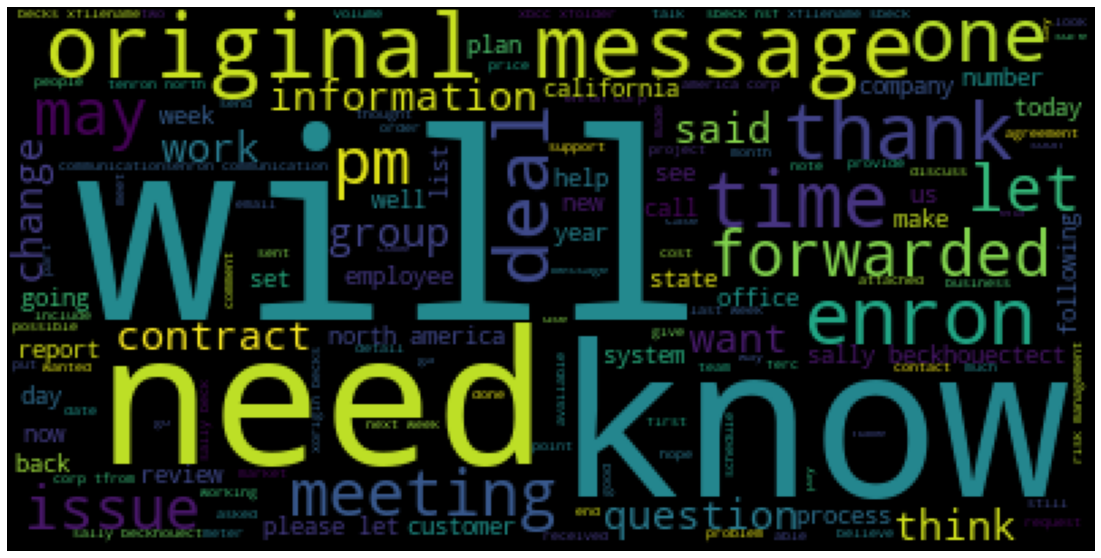

In [38]:
female_cloud = WordCloud(stopwords = STOPWORDS).generate(all_female_words)
plt.figure(figsize = (20,10))
plt.imshow(female_cloud)
plt.axis("off")
plt.show()

In [39]:
all_male_words = ' '.join(list(enron_male_sender['clean_text']))

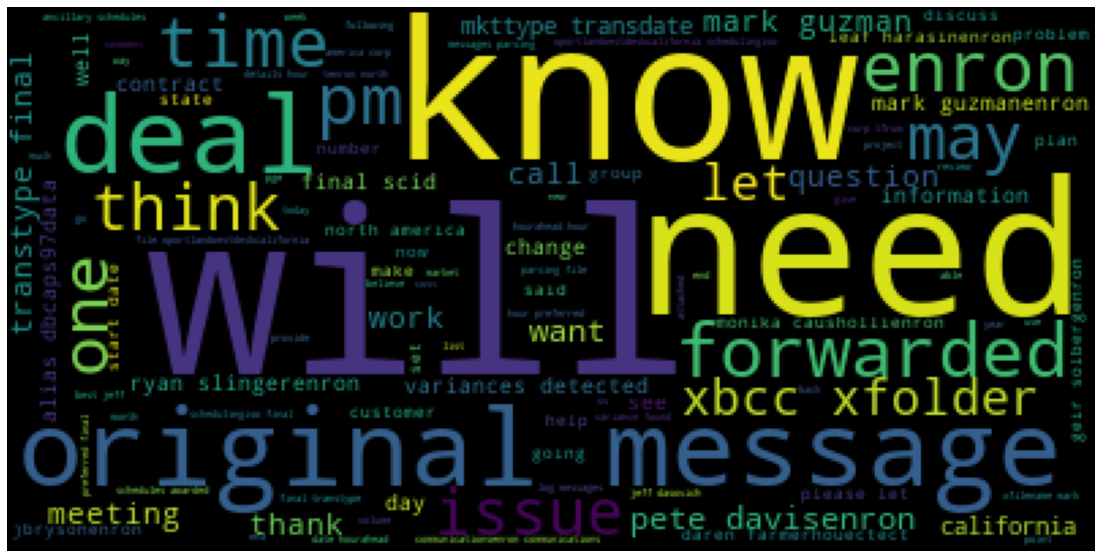

In [40]:
male_cloud = WordCloud(stopwords = STOPWORDS).generate(all_male_words)
plt.figure(figsize = (20,10))
plt.imshow(male_cloud)
plt.axis("off")
plt.show()

## Let's see if we need to be normalizing by the total number of words

In [41]:
enron_known_genders = enron_female_sender.append(enron_male_sender)
enron_known_genders.drop(columns = ['percent_apologetic', 'percent_uncertain', 'percent_appreciative', 'percent_confident'], inplace = True)

In [42]:
enron_known_genders['num_words'] = [len(row) for row in enron_known_genders['text_tokens']]

#we have one outlier that has over 25000 words - we will drop that 
enron_known_genders = enron_known_genders[~(enron_known_genders['num_words'] > 25000)]

In [43]:
enron_known_genders.head()

,index,date,sender,recipient1,subject,sender_name,recipient_name,sender_gender,recipient_gender,clean_text,...,num_uncertain,num_appreciative,num_confident,num_words,num_sad,num_familial,num_angry,num_happy,num_holidays,adjInEmail
0,347,2000-12-13 08:01:00-08:00,rebecca.cantrell@enron.com,phillip.allen@enron.com,Re:,Rebecca,Phillip,female,male,phillip is the value axis on sheet 2 of the s...,...,0,1,1,191,0,0,0,0,0,22
1,407,2000-12-13 05:26:00-08:00,stephanie.miller@enron.com,jeff.dasovich@enron.com,Re: Enron Response to San Diego Request for Ga...,Stephanie,Jeff,female,male,tpkaufmaenron.com richard.sandersenron.com tr...,...,0,0,0,163,0,0,0,0,0,24
2,474,2000-12-12 04:41:00-08:00,christi.nicolay@enron.com,phillip.allen@enron.com,Re: Talking points about California Gas market,Christi,Phillip,female,male,phillipto the extent that we can give chair ho...,...,0,2,2,261,0,0,0,0,0,17
3,506,2000-12-07 01:55:00-08:00,tiffany.miller@enron.com,phillip.allen@enron.com,System Development,Tiffany,Phillip,female,male,can you please review the following systems pr...,...,0,0,0,71,0,0,0,0,0,6
4,679,2000-12-07 01:55:00-08:00,tiffany.miller@enron.com,phillip.allen@enron.com,System Development,Tiffany,Phillip,female,male,can you please review the following systems pr...,...,0,0,0,71,0,0,0,0,0,6


Text(0, 0.5, 'number of apologetic words')

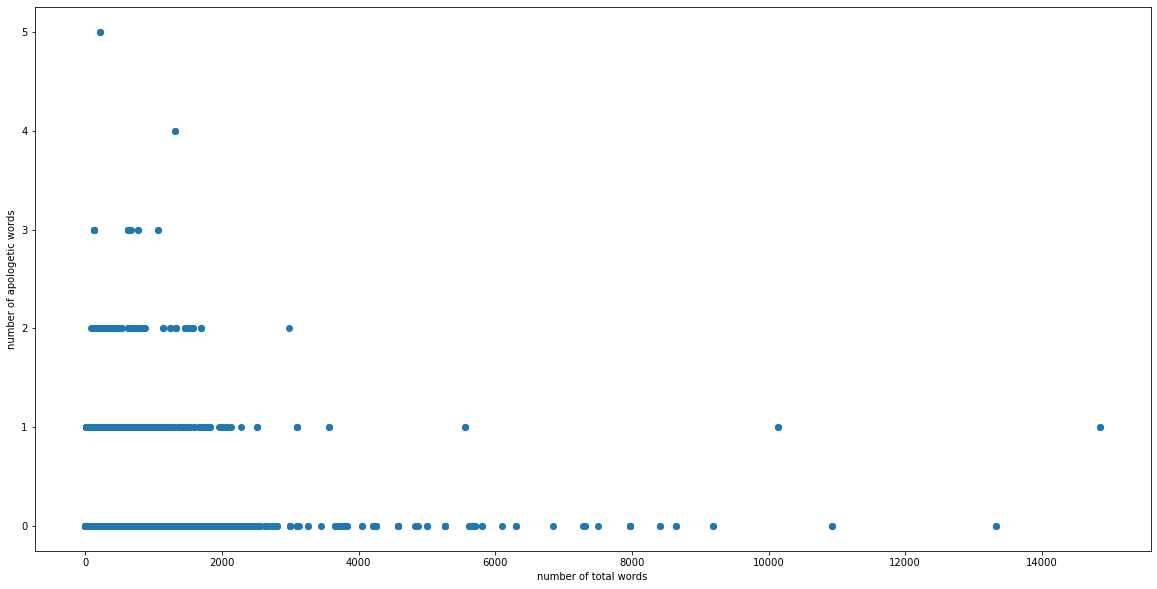

In [44]:
plt.figure(figsize = (20,10))
plt.scatter(enron_known_genders['num_words'], enron_known_genders['num_apologetic'])
plt.xlabel('number of total words')
plt.ylabel('number of apologetic words')

Text(0, 0.5, 'number of uncertain words')

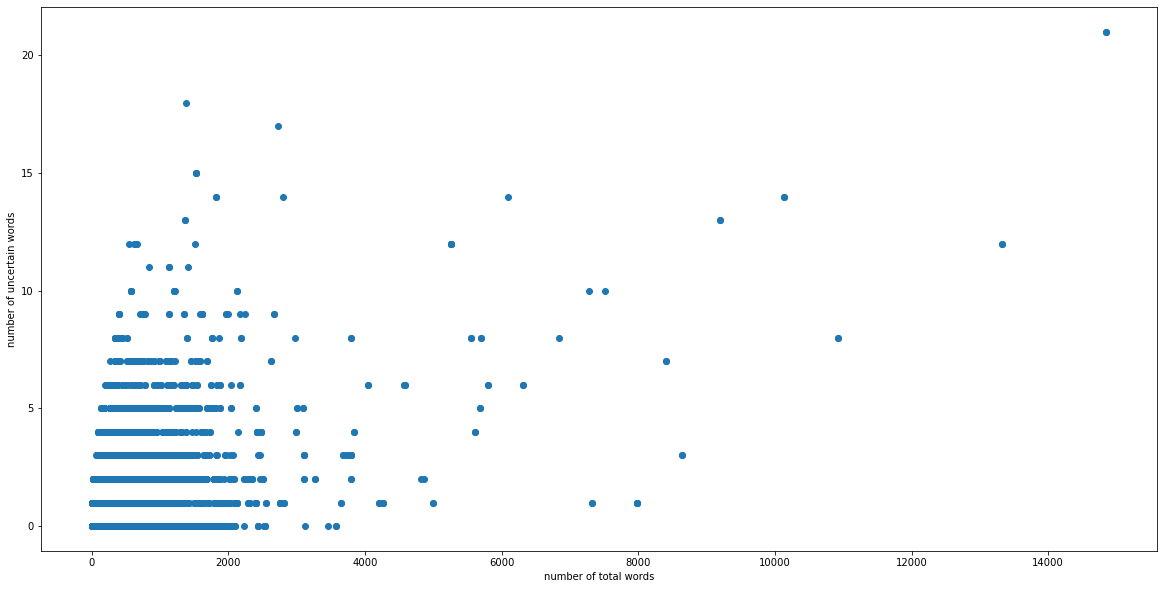

In [45]:
plt.figure(figsize = (20,10))
plt.scatter(enron_known_genders['num_words'], enron_known_genders['num_uncertain'])
plt.xlabel('number of total words')
plt.ylabel('number of uncertain words')

Text(0, 0.5, 'number of appreciative words')

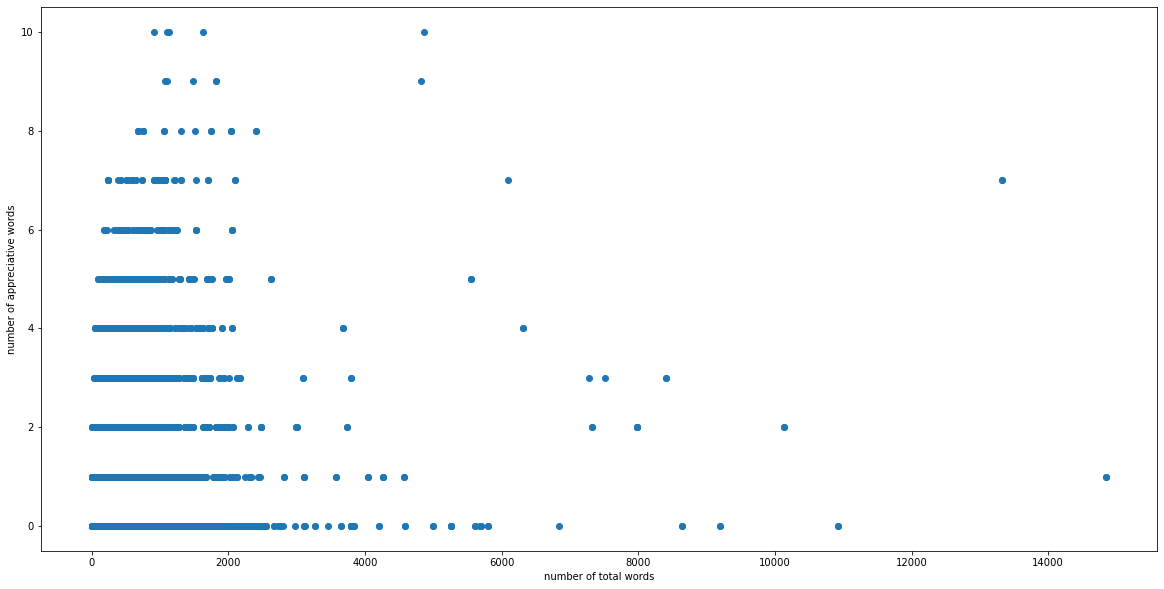

In [46]:
plt.figure(figsize = (20,10))
plt.scatter(enron_known_genders['num_words'], enron_known_genders['num_appreciative'])
plt.xlabel('number of total words')
plt.ylabel('number of appreciative words')

Text(0, 0.5, 'number of confident words')

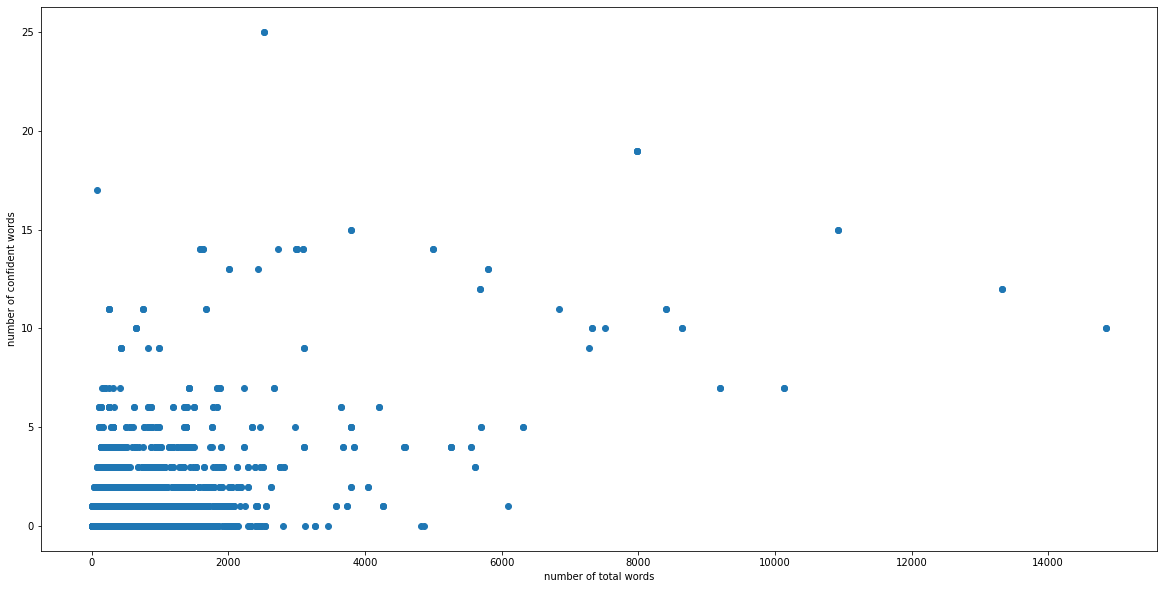

In [47]:
plt.figure(figsize = (20,10))
plt.scatter(enron_known_genders['num_words'], enron_known_genders['num_confident'])
plt.xlabel('number of total words')
plt.ylabel('number of confident words')

We don't see very much correlation above with the total number of words, so we will not standardize our values by that 

## Now let's start on building the model

In [49]:
enron_known_genders.head()

,index,date,sender,recipient1,subject,sender_name,recipient_name,sender_gender,recipient_gender,clean_text,...,num_uncertain,num_appreciative,num_confident,num_words,num_sad,num_familial,num_angry,num_happy,num_holidays,adjInEmail
0,347,2000-12-13 08:01:00-08:00,rebecca.cantrell@enron.com,phillip.allen@enron.com,Re:,Rebecca,Phillip,female,male,phillip is the value axis on sheet 2 of the s...,...,0,1,1,191,0,0,0,0,0,22
1,407,2000-12-13 05:26:00-08:00,stephanie.miller@enron.com,jeff.dasovich@enron.com,Re: Enron Response to San Diego Request for Ga...,Stephanie,Jeff,female,male,tpkaufmaenron.com richard.sandersenron.com tr...,...,0,0,0,163,0,0,0,0,0,24
2,474,2000-12-12 04:41:00-08:00,christi.nicolay@enron.com,phillip.allen@enron.com,Re: Talking points about California Gas market,Christi,Phillip,female,male,phillipto the extent that we can give chair ho...,...,0,2,2,261,0,0,0,0,0,17
3,506,2000-12-07 01:55:00-08:00,tiffany.miller@enron.com,phillip.allen@enron.com,System Development,Tiffany,Phillip,female,male,can you please review the following systems pr...,...,0,0,0,71,0,0,0,0,0,6
4,679,2000-12-07 01:55:00-08:00,tiffany.miller@enron.com,phillip.allen@enron.com,System Development,Tiffany,Phillip,female,male,can you please review the following systems pr...,...,0,0,0,71,0,0,0,0,0,6


In [50]:
enron_known_genders['sender_dummy'] = [1 if (val == 'female') else 0 for val in enron_known_genders['sender_gender'] ]

In [51]:
all_possible_features=  ['num_apologetic','num_uncertain', 'num_appreciative', 'num_confident', 'num_sad', 'num_familial', 'num_angry', 'num_happy', 'num_holidays', 'adjInEmail','num_words']

Let's start with just a basic model that only considers the number of words - we saw that the average number of words in females' emails was greater, so maybe that will be somewhat accurate!

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(enron_known_genders[['num_words']], enron_known_genders['sender_dummy'], test_size=0.2, random_state=34)

In [53]:
logist_simple = LogisticRegression(random_state = 0).fit(X_train, Y_train)

In [54]:
predicted_simple = logist_simple.predict(X_test)
predicted_probs_simple = logist_simple.predict_proba(X_test)
print(logist_simple.score(X_test,Y_test))

0.741988102091729


In [55]:
confusion_matrix(predicted_simple,Y_test)

array([[7723, 2683],
       [   6,   10]], dtype=int64)

In [56]:
print(logist_simple.coef_)

[[0.00037652]]


Hmmm.... that isn't a very high weight... let's try some more features

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(enron_known_genders[['num_apologetic', 'num_uncertain','num_appreciative', 'num_confident', 'num_sad', 'num_familial','num_angry', 'num_happy', 'num_holidays', 'adjInEmail', 'num_words']], enron_known_genders['sender_dummy'], test_size=0.2, random_state=34)

In [58]:
logist = LogisticRegression(random_state = 0).fit(X_train, Y_train)

C:\Users\baile\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [59]:
predicted_genders = logist.predict(X_test)
predicted_probs = logist.predict_proba(X_test)
print(logist.score(X_test,Y_test))

0.7402609863749761


In [60]:
confusion_matrix(predicted_genders,Y_test)

array([[7619, 2597],
       [ 110,   96]], dtype=int64)

In [61]:
print(logist.coef_)

[[ 0.20827098 -0.04696162  0.32681741  0.03636931  0.02528603  0.23988367
  -0.02827946  0.22347325  0.14239775 -0.00645523  0.00066139]]


HMMMM...looks like num_words still isn't very correlated. Let's try without it

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(enron_known_genders[['num_apologetic', 'num_uncertain','num_appreciative', 'num_confident', 'num_sad', 'num_familial','num_angry', 'num_happy', 'num_holidays', 'adjInEmail']], enron_known_genders['sender_dummy'], test_size=0.2, random_state=34)

In [63]:
logist = LogisticRegression(random_state = 0).fit(X_train, Y_train)

C:\Users\baile\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
predicted_genders = logist.predict(X_test)
predicted_probs = logist.predict_proba(X_test)
print(logist.score(X_test,Y_test))

0.7399731337555172


In [65]:
confusion_matrix(predicted_genders,Y_test)

array([[7610, 2591],
       [ 119,  102]], dtype=int64)

In [66]:
print(logist.coef_)

[[ 2.50135894e-01 -3.18267065e-02  3.34246988e-01  3.62664803e-02
   5.45179530e-02  1.90616404e-01 -5.71670137e-02  2.53005560e-01
   1.51126531e-01 -2.19225516e-04]]


In [67]:
'num_apologetic','num_appreciative', 'num_familial', 'num_happy', 'num_holidays'

('num_apologetic',
 'num_appreciative',
 'num_familial',
 'num_happy',
 'num_holidays')

What if we only look at the features that have larger weights?

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(enron_known_genders[all_possible_features], enron_known_genders['sender_dummy'], test_size=0.2, random_state=34)

In [69]:
logist = LogisticRegression(random_state = 0).fit(X_train, Y_train)

C:\Users\baile\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
predicted_genders = logist.predict(X_test)
predicted_probs = logist.predict_proba(X_test)
print(logist.score(X_test,Y_test))

0.7402609863749761


In [71]:
confusion_matrix(predicted_genders,Y_test)

array([[7619, 2597],
       [ 110,   96]], dtype=int64)

In [72]:
print(logist.coef_)

[[ 0.20827098 -0.04696162  0.32681741  0.03636931  0.02528603  0.23988367
  -0.02827946  0.22347325  0.14239775 -0.00645523  0.00066139]]


That was our best one yet!!! Let's stop there for now

In [73]:
#enron_known_genders.to_csv('final_enron_gender.csv')

In [76]:
#enron_known_genders = pd.read_csv('final_enron_gender.csv')

Let's Try K-Nearest-Neighbor Method

In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(enron_known_genders[all_possible_features], enron_known_genders['sender_dummy'], test_size=0.2, random_state=34)

In [78]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=2)
classifier.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=2)

In [79]:
Y_pred = classifier.predict(X_test)

In [80]:
confusion_matrix(Y_pred, Y_test)

array([[7342, 1591],
       [ 387, 1102]], dtype=int64)

In [81]:
classifier.score(X_test, Y_test)

0.8102091729034734

KNN was better than any of our Logistic Regression Models!

Let's try  decision trees

In [82]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)

In [83]:
clf.score(X_test, Y_test)

0.8426405680291691

In [84]:
Y_pred = clf.predict(X_test)
confusion_matrix(Y_pred, Y_test)

array([[7168, 1079],
       [ 561, 1614]], dtype=int64)

Let's use Support Vector Machines

In [85]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, Y_train)

SVC()

In [86]:
clf.score(X_test, Y_test)

0.742084052964882

In [87]:
confusion_matrix(Y_pred, Y_test)

array([[7168, 1079],
       [ 561, 1614]], dtype=int64)

Let's try Multinomial Naive Bayes

In [88]:
from sklearn.naive_bayes import MultinomialNB

In [89]:
mnb = MultinomialNB()
mnb.fit(X_train, Y_train)
Y_pred = mnb.predict(X_test)

In [90]:
mnb.score(X_test, Y_test)

0.7414123968528114

In [91]:
confusion_matrix(Y_pred, Y_test)

array([[7663, 2629],
       [  66,   64]], dtype=int64)

Next, Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

In [93]:
Y_pred = clf.predict(X_test)

In [94]:
clf.score(X_test, Y_test)

0.8487814239109576

In [95]:
confusion_matrix(Y_pred, Y_test)

array([[7201, 1048],
       [ 528, 1645]], dtype=int64)

In [96]:
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler


In [97]:
ros = RandomOverSampler(random_state=0)

In [98]:
X_resampled, y_resampled = ros.fit_resample(X_train, Y_train)

In [100]:
y_resampled.sum() / len(y_resampled)

0.5

In [101]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_resampled, y_resampled)

In [102]:
clf.score(X_test, Y_test)

0.8121281903665324

In [103]:
Y_pred_oversample = clf.predict(X_test)
confusion_matrix(Y_pred_oversample, Y_test)

array([[6576,  805],
       [1153, 1888]], dtype=int64)

Random Forest and Oversampling

In [104]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=0)

In [105]:
clf.score(X_test, Y_test)

0.8133755517175206

we aren't seeing that the oversampling techniques make a difference

## Finally, we will do significance tests on our data to assess three things:
 
 1) Is there a difference between the mean number of words that men and women use?  
 2) Is there a difference between the number of apologetic words used per email by men and women?  
 3) Is there a difference between the number of personal/emotional words used per email by men and women?  

### Because we want to compare the means of two independent samples (men and women), we will use a 2 sample t test

Null hypothesis 1 =  There is no difference between the average amount of words send by men and by women  
Alternative hypothesis 1 = There is a difference between the average amount of words sent by men and women

1 tailed alt. hypothesis 1 = Men send less words on average than women in professional emails at Enron

In [107]:
t, p_value = stats.ttest_ind(enron_female_sender['num_words'], enron_male_sender['num_words'])

print('2 tailed t test result: ', p_value)
print('1 tailed t test result: ', p_value / 2)

2 tailed t test result:  1.0338554742711565e-43
1 tailed t test result:  5.169277371355782e-44


Because the p value is so small, we see that the average number of words that men send in their emails is significantly different than the number women say - the men's average is less than the women's. We reject the null hypothesis

Null hypothesis 2 =  There is no difference between the average amount of personal or emotional words send by men and by women  
Alternative hypothesis 2 = There is a difference between the average amount of personal or emotional words sent by men and women

1 tailed alt. hypothesis 2 = Men send less emotional and personal life words on average than women in professional emails at Enron

In [108]:
#add a column that combines all of the personal words
enron_female_sender['num_personal'] = enron_female_sender['num_holidays'] + enron_female_sender['num_happy'] + enron_female_sender['num_sad'] + enron_female_sender['num_familial'] + enron_female_sender['num_angry']
enron_male_sender['num_personal'] = enron_male_sender['num_holidays'] + enron_male_sender['num_happy'] + enron_male_sender['num_sad'] + enron_male_sender['num_familial'] + enron_male_sender['num_angry']

In [110]:
t, p_value = stats.ttest_ind(enron_female_sender['num_personal'], enron_male_sender['num_personal'])

print('2 tailed t test result: ', p_value)
print('1 tailed t test result: ', p_value / 2)

2 tailed t test result:  4.375130518239689e-80
1 tailed t test result:  2.1875652591198446e-80


the p value is very small - we reject our null hypothesis

Null hypothesis 3 =  There is no difference between the average amount of apologetic words send by men and by women  
Alternative hypothesis 3 = There is a difference between the average amount of apologetic words sent by men and women

1 tailed alt. hypothesis 3 = Men send less apologetic words on average than women in professional emails at Enron

In [111]:
t, p_value = stats.ttest_ind(enron_female_sender['num_apologetic'], enron_male_sender['num_apologetic'])

print('2 tailed t test result: ', p_value)
print('1 tailed t test result: ', p_value / 2)

2 tailed t test result:  1.5083804423799829e-27
1 tailed t test result:  7.541902211899914e-28


the p value is very small - we reject our null hypothesis

## Overall, we found that there is a significant difference in the way that men and women communicate in the workplace. We were able to classify emails by gender with a high accuracy and we found that the number of words used, the number of personal life words used, and the number of words with an apologetic connotation were highly statistically significant 